In [1]:
# load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import yfinance as yf

In [2]:
# Download Max History for S&P 500
print("Downloading S&P 500 data from Yahoo Finance...")
try:
    df = yf.download("^GSPC", period="max", progress=False, auto_adjust=False)
    
    # Handle potential MultiIndex columns (allows for easier reading)
    if isinstance(df.columns, pd.MultiIndex):
        # If columns are like ('Adj Close', '^GSPC'), drop the ticker level
        df.columns = df.columns.get_level_values(0)
        
    # Ensure index is datetime and sorted
    df.index = pd.to_datetime(df.index)
    df.sort_index(inplace=True)
    
    print(f'Loaded {len(df)} days of market data.')
    print(f'Data range: {df.index.min().date()} to {df.index.max().date()}')

except Exception as e:
    print(f"ERROR: Could not download data. {e}")
    sys.exit(1)

Loaded 24596 days of market data.
Data range: 1927-12-30 to 2025-12-01


In [3]:
# Resample to Annual Data ('YE' = Year End) to match our retirement simulation steps
# We take the last price of each year
df_yearly = df['Adj Close'].resample('YE').last()
df_yearly = df_yearly[:-1] #Current year is incomplete
# Calculate ANNUAL returns
#Drop the first value, no comparison
historical_returns = df_yearly.pct_change().dropna().values

print(f"Historical Data Processed: {len(historical_returns)} years")
print(f"Avg Annual Return: {np.mean(historical_returns):.3%}")
print(f"Standard Deviation: {np.std(historical_returns):.3%}")

Historical Data Processed: 97 years
Avg Annual Return: 8.012%
Standard Deviation: 18.940%


In [4]:
# User Defining Parameters
start_age = 25
retirement_age = 65
life_expectancy = 95 # Stress Test
years_to_sim = life_expectancy - start_age
starting_savings = 10000
annual_contribution = 10000 
spending_in_retirement = 60087 # Average yearly retirement spending (Investopedia)

# Risk Parameters
health_shock_prob = 0.01    # 1% chance per year of a major health issue (Google Gemini)
health_shock_cost = 5000   # Cost of that health issue (Google Gemini)

num_simulations = 5000

In [5]:
# Monte-Carlo simulation
# Rows = Simulation Number
# Columns = Year 
# (Index 0 is start year)
sim_matrix = np.zeros((num_simulations, years_to_sim + 1))
sim_matrix[:, 0] = starting_savings #Everyone starts with their original savings

# Create an array to track if a simulation has "failed" (ran out of money)
# We track this to stop withdrawing money if you are already broke
is_broke = np.zeros(num_simulations, dtype=bool)
for year in range(1, years_to_sim + 1): #BOOTSTRAPPING (sampling from our limited data)
    current_age = start_age + year
    market_return = np.random.choice(historical_returns, size=num_simulations, replace=True)
    
    # Health Catastrophe (Bernoulli)
    health_shocks = np.random.binomial(1, health_shock_prob, size=num_simulations)
    annual_health_costs = health_shocks * health_shock_cost
    
    # If age < 65: We add contributions (Saving phase)
    # If age >= 65: We subtract spending (Retirement phase)
    cash_flow = np.where(current_age < retirement_age, annual_contribution, -spending_in_retirement)
    
    # Update Balence
    prev_balance = sim_matrix[:, year - 1]
    
    # (Old * Growth) + Cash Flow - Health Costs
    new_balance = prev_balance * (1 + market_return) + cash_flow - annual_health_costs
    
    # No negative savings in this model
    new_balance = np.maximum(new_balance, 0)
    
    sim_matrix[:, year] = new_balance

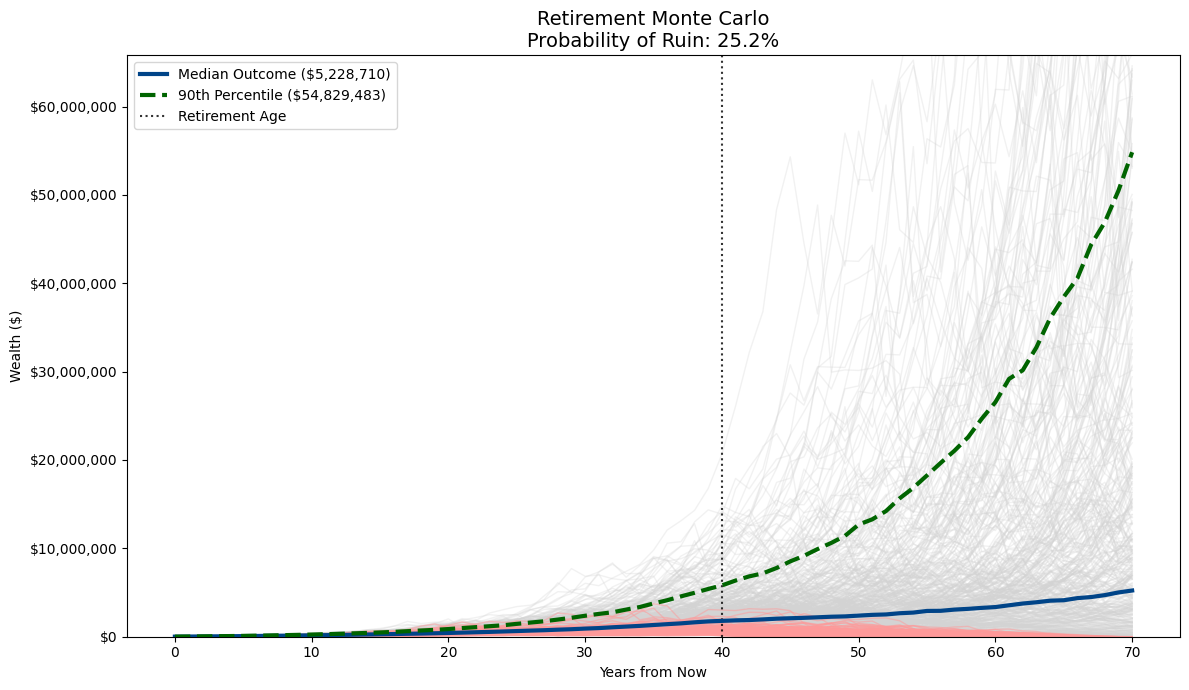

In [10]:
plt.figure(figsize=(12, 7))

# Plot Individual Paths
for i in range(500): 
    path = sim_matrix[i, :]
    
    if path[-1] == 0:
        color = '#ff9999' # Light red (Ruin)
        alpha = 0.5       
        zorder = 1       
    else:
        color = 'lightgray'
        alpha = 0.3       
        zorder = 0       
        
    plt.plot(path, color=color, alpha=alpha, linewidth=1, zorder=zorder)

# Plot Summary Statistics
plt.plot(median_path, color='#004488', linewidth=3, zorder=10, 
         label=f'Median Outcome (${median_path[-1]:,.0f})')

plt.plot(percentile_90_path, color='#006400', linewidth=3, linestyle='--', zorder=10, 
         label=f'90th Percentile (${percentile_90_path[-1]:,.0f})')

plt.axvline(x=retirement_age - start_age, color='black', linestyle=':', alpha=0.8, label='Retirement Age')

plt.title(f'Retirement Monte Carlo\nProbability of Ruin: {prob_ruin:.1%}', fontsize=14)
plt.xlabel('Years from Now')
plt.ylabel('Wealth ($)')
plt.legend(loc='upper left')

# Format Dollars on Y-Axis
ax = plt.gca()
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# This cuts off the extreme outliers but keeps the "Green" line clearly visible.
top_limit = percentile_90_path[-1] * 1.2
plt.ylim(0, top_limit) 
plt.tight_layout()
plt.show()